# 딥러닝을 활용한 식물 잎 사진으로 질병 분류하기

# 0. 기초 셋팅

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')   # 구글 드라이브 마운트(쥬피터노트북 환경에서는 gpu사용불가로인해 모델학습에서 오류)

Mounted at /content/drive


In [2]:
# 프로젝트 폴더 하위에 "dataset" 폴더가 만들어져있어야합니다.
os.chdir("/content/drive/MyDrive/jc_deeplearning_project/dataset")  # 압축풀기위해 데이터셋폴더로 지정

In [3]:
# "dataset"폴더안에 "dataset.zip"파일이 있어야합니다.
!unzip -qq "/content/drive/MyDrive/jc_deeplearning_project/dataset/dataset.zip" # 데이터셋 압축해제(5분정도 소요), 

In [4]:
import shutil
src_path1 = '/content/drive/MyDrive/jc_deeplearning_project/dataset/dataset.zip'  
dst_path1 = '/content/drive/MyDrive/jc_deeplearning_project/dataset.zip'

shutil.move(src_path1, dst_path1)  # 기존 data셋 내에 있는 dataset.zip파일을 프로젝트 폴더로 옮기기(오류방지)

'/content/drive/MyDrive/jc_deeplearning_project/dataset.zip'

In [5]:
os.chdir("/content/drive/MyDrive/jc_deeplearning_project")  # 압축해제 완료후 작업폴더로 다시 이동

# 1-1 데이터 분할을 위한 폴더 생성

In [6]:
import os
import shutil
 
original_dataset_dir = './dataset'             # 원본데이터 셋이 위치한 경로를 지정
classes_list = os.listdir(original_dataset_dir)# 해당폴더 하위에 있는 모든폴더 목록 가져옴 
                                               # 폴더목록 = 클래스목록 => class_list로 저장
base_dir = './splitted'                        # 나눈데이터를 저장할 폴더를 생성
os.mkdir(base_dir)
 
train_dir = os.path.join(base_dir, 'train')    # 분리후에 각 데이터를 저장할 하위폴더 생성(train, val, test)
os.mkdir(train_dir)                            
validation_dir = os.path.join(base_dir, 'val')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

for cls in classes_list:                       # train, validation, test 폴더 하위에 각각 클래스 목록 폴더를 재생성
    os.mkdir(os.path.join(train_dir, cls))
    os.mkdir(os.path.join(validation_dir, cls))
    os.mkdir(os.path.join(test_dir, cls))

# 1-2 데이터 분할과 클래스별 데이터 수 확인

In [7]:
import math
 
for cls in classes_list:                               # for문을 통해 모든클래스에서 작업 반복
    path = os.path.join(original_dataset_dir, cls)
    fnames = os.listdir(path)                          # path의치에 존재하는 모든 이미지 파일의 목록수를 frame 변수에 저장
 
    train_size = math.floor(len(fnames) * 0.6)         # 훈련, 검증, 테스트 셋트의 비율 지정(6:2:2)
    validation_size = math.floor(len(fnames) * 0.2)    
    test_size = math.floor(len(fnames) * 0.2)
    
    train_fnames = fnames[:train_size]                 # train 데이터에 해당하는 파일이름은 frain_franmes로 저장
    print("Train size(",cls,"): ", len(train_fnames))
    for fname in train_fnames:                        # 모든 train 데이터에 대해 for문의 내용 반복
        src = os.path.join(path, fname)                # 복사할 파일 경로지정
        dst = os.path.join(os.path.join(train_dir, cls), fname)   # 복사한 후 저장할 파일 경로 지정
        shutil.copyfile(src, dst)                      # scr의 경로에 해당하는 파일을 dst경로에 저장
        
    validation_fnames = fnames[train_size:(validation_size + train_size)] # 반복
    print("Validation size(",cls,"): ", len(validation_fnames))
    for fname in validation_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(validation_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    test_fnames = fnames[(train_size+validation_size):(validation_size + train_size +test_size)]

    print("Test size(",cls,"): ", len(test_fnames))
    for fname in test_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        shutil.copyfile(src, dst)

Train size( Pepper,_bell___healthy ):  886
Validation size( Pepper,_bell___healthy ):  295
Test size( Pepper,_bell___healthy ):  295
Train size( Grape___Esca_(Black_Measles) ):  829
Validation size( Grape___Esca_(Black_Measles) ):  276
Test size( Grape___Esca_(Black_Measles) ):  276
Train size( Pepper,_bell___Bacterial_spot ):  598
Validation size( Pepper,_bell___Bacterial_spot ):  199
Test size( Pepper,_bell___Bacterial_spot ):  199
Train size( Strawberry___healthy ):  273
Validation size( Strawberry___healthy ):  91
Test size( Strawberry___healthy ):  91
Train size( Grape___Black_rot ):  708
Validation size( Grape___Black_rot ):  236
Test size( Grape___Black_rot ):  236
Train size( Corn___Common_rust ):  715
Validation size( Corn___Common_rust ):  238
Test size( Corn___Common_rust ):  238
Train size( Apple___Apple_scab ):  378
Validation size( Apple___Apple_scab ):  126
Test size( Apple___Apple_scab ):  126
Train size( Potato___healthy ):  91
Validation size( Potato___healthy ):  30


# 1-3 학습을 위한 준비

In [8]:
import torch
import os
 
USE_CUDA = torch.cuda.is_available()  # GPU를 사용할수 있는지 확인(True - 사용, Fale - 불가)
DEVICE = torch.device("cuda" if USE_CUDA else "cpu") # GPU사용가능하면 CUDA사용, 아니면 CPU사용
BATCH_SIZE = 256   # 배치사이즈 한번에 바꾸기위해 변수로 등록
EPOCH = 16         # 에포크횟수도 미리 변수로 등록

In [9]:
print(USE_CUDA, DEVICE)

True cuda


In [10]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 
 
transform_base = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()]) 
# transforms.Compose() : 이미지 전처리 및 Augmentation 매서드
# transforms.Resize((64,64)) : 사이즈 조정
# transforms.ToTensor() : 이미지를 텐서형태로 변환, 모든값을 0~1사이로 정규화

train_dataset = ImageFolder(root='./splitted/train', transform=transform_base) 
# 데이터셋 불러오는 메서드

val_dataset = ImageFolder(root='./splitted/val', transform=transform_base)
# 검증데이터를 val에서 불러옴

In [11]:
from torch.utils.data import DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
# 불러온 이미지 데이터를 주어진 조건에 따라 미니 배치 단위로 분리하는 역할 수행
# 셔플 = True로 하면 데이터의 순서가 섞여 모델이 학습할때 순서를 기억하는 것을 방지함
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
# 검증데이터도 동일하게 셋팅

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# 2-1 모델 설계

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
class Net(nn.Module): # nn.Module클래스 상속
  
    def __init__(self): 
    
        super(Net, self).__init__() # nn.Module 내에 있는 매서드 상속받아 사용

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # 첫번째 conv2d 정의(채널수,출력채널수,커널크기)
        self.pool = nn.MaxPool2d(2,2)  # maxPooling 정의 커널크기, 스트라이드
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 입력채널 수 32, 출력채널수 64, 커널크기 3인 2d conv 정의
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1) # 입력채널 수 64, 출력채널수 64, 커널크기 3인 2d conv 정의

        self.fc1 = nn.Linear(4096, 512)              # 플래튼 이후에 사용될 첫번째 fully cennected 레이어 정의
        self.fc2 = nn.Linear(512, 33)                # 플래튼 이후에 사용될 두번째 fully cennected 레이어 정의
    
    def forward(self, x):  
    
        x = self.conv1(x)                            # 첫번째 conv2d를 이용해 conv연산진행후 feature map 생성
        x = F.relu(x)                                # 렐루함수 적용
        x = self.pool(x)                             # 맥스 풀링 적용
        x = F.dropout(x, p=0.25, training=self.training)  # 맥스풀링 결과값에 드랍아웃 적용(25%)

        x = self.conv2(x)                            # 두번째 conv2d를 이용해 conv연산진행후 feature map 생성
        x = F.relu(x) 
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv3(x)                            # 세번째 conv2d를 이용해 conv연산진행후 feature map 생성
        x = F.relu(x) 
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training)

        x = x.view(-1, 4096)                         # 생성된 feature map을 1차원으로 펼침(Flatten)
        x = self.fc1(x)                              # Flatten 된 1차원 tensor를 fc1에 통과
        x = F.relu(x) 
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)                              # 모델의 마지막 레이어

        return F.log_softmax(x, dim=1)              # 마지막 레이어 33개 결과값에 소프트맥스 합수 적용
                                                     # 각 클래스에 속할 확률을 output값으로 출력

model_base = Net().to(DEVICE)                        # 정의한 cnn모델 net()의 새로운 객체를 생성
optimizer = optim.Adam(model_base.parameters(), lr=0.001) # 옵티마지저 = 아담, 러닝레이트 0,001


# 2-2 모델 학습을 위한 함수

In [13]:
def train(model, train_loader, optimizer):
    model.train()                                              # 입력받은 모델을 학습모드로 설정
    for batch_idx, (data, target) in enumerate(train_loader): # batch인덱스,(data, target) 형태로 for문 실행
        data, target = data.to(DEVICE), target.to(DEVICE)      
        optimizer.zero_grad()                                  # 옵티마이저 초기화
        output = model(data)                                   # 데이터를 모델에 입력하여 output 값 계산
        loss = F.cross_entropy(output, target)                 # 모델에서 계산한 output값인 예측값과 타겟값 사이의 loss 계산
        loss.backward()                                        # 계산한 loss값을 바탕으로 그레디언트값을 각 파라미터에 할당
        optimizer.step()                                       # 각 파라미터에 할당된 그레디언트 값을 이용해 모델의 파라미터 업데이트

# 2-3 모델 평가를 위한 함수

In [14]:
def evaluate(model, test_loader):
    model.eval()                     # 입력받은 모델을 평가모델로 설정
    test_loss = 0                    # 미니 배치별로 loss를 합산에서 저장할변수 생성
    correct = 0                      # 올바르게 예측한 데이터 세는 변수 생성
    
    with torch.no_grad():           # 모델을 평가 할때는 파라미터 업데이트를 하지 않아야됨, 업데이트 중단하는 메서드 생성
        for data, target in test_loader:  # 데이터와 대응하는 label값 접근
            data, target = data.to(DEVICE), target.to(DEVICE)  
            output = model(data)           # 데이터를 모델에 입력하여 output 계산
            
            test_loss += F.cross_entropy(output,target, reduction='sum').item()  
            # 모델에서 계산한 output값인 예측값과 타겟값 사이의 로스 계산
            
            pred = output.max(1, keepdim=True)[1]                # 모델에 입력된 test데이터가 33개의 클래스에 속할 각각의 확률값이 output으로 출력
                                                                  # 이중 가장 높은 값을 가진 인덱스를 예측값으로 저장
            correct += pred.eq(target.view_as(pred)).sum().item() # target tensor의 구조를 pred tensor와 같은 모양으로 정렬
   
    test_loss /= len(test_loader.dataset)                         # 모든 미니 배치에서 합한 loss값을 배치수로 나누어 미니배치마다 계산된 loss값의 평균을 구함
    test_accuracy = 100. * correct / len(test_loader.dataset)     # 모든 미니배치에서 합한 정확도 값을 batch수로 나누어 미니 배치마다 계산된 정확도 값의 평균을 구함
    return test_loss, test_accuracy                              # 측정한 test loss와 정확도를 반환

# 2-3 모델 학습 실행 및 결과 확인

In [15]:
import time
import copy
 
def train_baseline(model ,train_loader, val_loader, optimizer, num_epochs = 30):
    best_acc = 0.0                                        # 가장 높은 모델 저장하는 변수 설정
    best_model_wts = copy.deepcopy(model.state_dict())    # 가장 정확도가 높은 모델 저장하는 변수 설정
 
    for epoch in range(1, num_epochs + 1): 
        since = time.time()                                   # 에포크당 소요시간 측정위해 시각 저장
        train(model, train_loader, optimizer)                 # 모델 학습
        train_loss, train_acc = evaluate(model, train_loader) # 트레인 데이터 로스 정확도 계산
        val_loss, val_acc = evaluate(model, val_loader)       # 검증데이터 로스 정확도 계산
        
        if val_acc > best_acc:                                # 에포크에서 최고 정확도 저장
            best_acc = val_acc 
            best_model_wts = copy.deepcopy(model.state_dict())
        
        time_elapsed = time.time() - since                                # 에포크 소요시간 계산
        print('-------------- epoch {} ----------------'.format(epoch))    
        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))  # 트레인 로스 정확도 출력
        print('val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))        # 검증 로스 정확도 출력
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) # 에포크당 소요시간 출력
    model.load_state_dict(best_model_wts)  # 최종적으로 정확도가 가장 높은 모델 불러온뒤 반환
    return model
    
 

base = train_baseline(model_base, train_loader, val_loader, optimizer, EPOCH)  	 # baseline 모델 학습
torch.save(base,'baseline.pt') # 학습된 모델을 저장

-------------- epoch 1 ----------------
train Loss: 1.8620, Accuracy: 47.19%
val Loss: 1.8727, Accuracy: 46.33%
Completed in 2m 6s
-------------- epoch 2 ----------------
train Loss: 1.2154, Accuracy: 63.45%
val Loss: 1.2414, Accuracy: 62.12%
Completed in 1m 53s
-------------- epoch 3 ----------------
train Loss: 0.9139, Accuracy: 72.36%
val Loss: 0.9520, Accuracy: 70.53%
Completed in 1m 51s
-------------- epoch 4 ----------------
train Loss: 0.8241, Accuracy: 74.32%
val Loss: 0.8660, Accuracy: 73.48%
Completed in 1m 52s
-------------- epoch 5 ----------------
train Loss: 0.5991, Accuracy: 81.63%
val Loss: 0.6540, Accuracy: 79.71%
Completed in 1m 51s
-------------- epoch 6 ----------------
train Loss: 0.5519, Accuracy: 83.61%
val Loss: 0.6060, Accuracy: 81.70%
Completed in 1m 52s
-------------- epoch 7 ----------------
train Loss: 0.5498, Accuracy: 82.50%
val Loss: 0.6126, Accuracy: 80.17%
Completed in 1m 52s
-------------- epoch 8 ----------------
train Loss: 0.3761, Accuracy: 88.86%


# 4. 모델 평가
# 4-1 베이스라인 모델 평가를 위한 전처리하기

In [16]:
transform_base = transforms.Compose([transforms.Resize([64,64]),transforms.ToTensor()])
test_base = ImageFolder(root='./splitted/test',transform=transform_base)  
test_loader_base = torch.utils.data.DataLoader(test_base, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# 4-3 베이스라인 모델 성능 평가하기

In [17]:
baseline=torch.load('baseline.pt') 
baseline.eval()  
test_loss, test_accuracy = evaluate(baseline, test_loader_base)

print('baseline test acc:  ', test_accuracy)

baseline test acc:   91.28802102891476


In [44]:
lp_train_loss = [1.862,1.2154,0.9139,0.8241,0.5991,0.5519,0.5498,0.3761,0.328,0.3345,0.2825,0.2662,0.2559,0.2192,0.1927,0.2082]
lp_train_accuracy = [0.47,0.63, 0.72, 0.74, 0.82, 0.84, 0.83, 0.89, 0.90, 0.90, 0.91, 0.92, 0.92, 0.94, 0.95, 0.94]

lp_val_loss = [1.8727,1.2414, 0.952, 0.866, 0.654, 0.606, 0.6126, 0.4422, 0.4051, 0.4186, 0.3758, 0.3567, 0.3521, 0.3182, 0.2935, 0.315]
lp_val_accuracy = [0.46, 0.62, 0.71, 0.73, 0.80, 0.82, 0.80, 0.86, 0.87, 0.86, 0.88, 0.88, 0.88, 0.90, 0.91, 0.90]

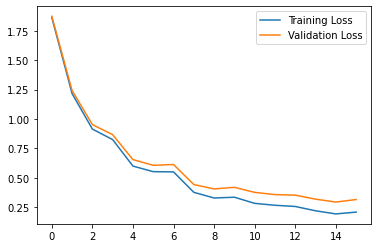

In [48]:
import matplotlib.pyplot as plt
epoch = range(16)
fig, ax = plt.subplots()
ax.plot(epoch, lp_train_loss, label='Training Loss')
ax.plot(epoch, lp_val_loss, label='Validation Loss')
ax.legend()
plt.show()

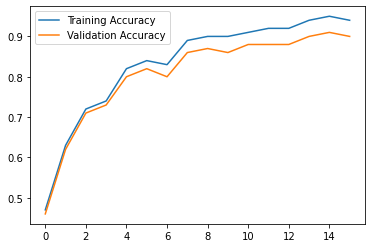

In [49]:
import matplotlib.pyplot as plt
epoch = range(16)
fig, ax = plt.subplots()
ax.plot(epoch, lp_train_accuracy, label='Training Accuracy')
ax.plot(epoch, lp_val_accuracy, label='Validation Accuracy')
ax.legend()
plt.show()

# 3-1. Transfer Learning 모델 학습
### Transfer Learning을 위한 준비

In [37]:
data_transforms = {
    'train': transforms.Compose([            # transforms.Compose() = 전처리, Augumentation에서 사용되는 메서드
        transforms.Resize([64,64]),          # 이미지 크기를 64*64로 조정
        transforms.RandomHorizontalFlip(),   # Augumentation 1 이미지 좌우 반전
        transforms.RandomVerticalFlip(),     # Augumentation 2 이미지 상하 반전
        transforms.RandomCrop(52),           # Augumentation 3 이미지 일부를 랜덤하게 잘라서 52*52 사이즈로 변경
        transforms.ToTensor(),               # 이미지를 텐서형태로 변환하고 모든숫자를 0~1사이로 변경
        transforms.Normalize([0.485, 0.456, 0.406],      #  RGB 채널값에서 정규화를 적용할 평균값
                             [0.229, 0.224, 0.225]) ]),  #  RGB 채널값에서 정규화를 적용할 표준편차값
    
    'val': transforms.Compose([
        transforms.Resize([64,64]),  
        transforms.RandomCrop(52),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]) ])
}

In [38]:
data_dir = './splitted'        # 학습데이터와 검증데이터를 불러올 폴더 경로 설정
image_datasets = {x: ImageFolder(root=os.path.join(data_dir, x),       #  데이터셋 불러오는 매서드, ROOT:경로, transform 불러온후 전처리 방법
                                 transform=data_transforms[x]) for x in ['train', 'val']} 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],       # 미니 배치 단위로 분리하는 역할
                                              batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
               for x in ['train', 'val']} 
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}   # 학습데이터와 검증데이터의 총 개수 각각 저장

class_names = image_datasets['train'].classes  # 33개의 클래스 이름 목록을 저장

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# 3-2 Pre-Trained Model 불러오기

In [39]:
from torchvision import models
 
resnet = models.resnet50(pretrained=True)      # RensNet 모델 불러오기, pretrained로 미리 학습된 모델의 파라미터값 그대로 가져오기
num_ftrs = resnet.fc.in_features               # 마지막 레이어의 입력 채널수를 저장 
resnet.fc = nn.Linear(num_ftrs, 33)            # 입력체널수를 기존 레이어에 맞추고, 출력체널수를 33개로 설정
resnet = resnet.to(DEVICE)
 
criterion = nn.CrossEntropyLoss()             # 로스함수 : 크로스 엔트로피 로스
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001) # 옵티마이저 아담, 
 
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)  # 에포크에 따라 러닝레이트 변경

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [40]:
resnet.fc.in_features

2048

# 3-3 Pre-Trained Model의 일부 Layer Freeze하기

In [41]:
ct = 0  # 해당 레이어가 몇번째 레이어 인지 나타내기 위해 변수 생성
for child in resnet.children():  # resnet의 모든 레이어 정보를 담고 있음
    ct += 1  
    if ct < 6:    #  ResNet50에 존재하는 10개의 레이어중에서 1~5번 레이어의 파라미터는 업데이트 되지않도록 고정하고 6~10번은 학습과정에서 업데이트하도록 설정
        for param in child.parameters():   
            param.requires_grad = False   # 레이어 번호가 6보다 작을 경우 파라미터가 업데이트 되지 않도록 설정

# 3-4 Transfer Learning 모델 학습과 검증을 위한 함수

In [42]:
def train_resnet(model, criterion, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())   # 정확도가 가장 높은 모델을 저장
    best_acc = 0.0                                       # 정확도가 가장 높은 모델의 정확도를 저장
    
    for epoch in range(num_epochs):
        print('-------------- epoch {} ----------------'.format(epoch+1))  # 현재 진행중인 에포크 출력
        since = time.time()                                                # 에포크당 소요되는 시간을 측정하기 위해 에포크 시작할때 시각 저장
        for phase in ['train', 'val']:                                    # 한 에포크는 각각 학습단계와 검증 단계를 갖음, for문을 통해 한 에포크 마다 학습모드와 검증모드를 각각 실행
            if phase == 'train': 
                model.train() 
            else:
                model.eval()     
 
            running_loss = 0.0        # 모든 데이터의 로스를 합산할 변수
            running_corrects = 0      # 올바르게 예측한 경우의 수를 세는 변수
 
            
            for inputs, labels in dataloaders[phase]: # 현대 모드에 해당하는 데이터로더에서 데이터를 입력받음
                inputs = inputs.to(DEVICE)  
                labels = labels.to(DEVICE)  
                
                optimizer.zero_grad() 
                
                with torch.set_grad_enabled(phase == 'train'):  # 학습단계에서만 그레디언트 업데이트, 검증단계에서는 업데이트 않음
                    outputs = model(inputs)                     # 데이터를 모델에 입력하여 아웃풋 계산
                    _, preds = torch.max(outputs, 1)            # 모델에 입력된 test 데이터가 33개의 클래스에 속할 확률을 output으로 출력, 이중 가장 높은 값을 가진 인덱스를 예측값으로 저장
                    loss = criterion(outputs, labels)           # 모델에서 계산한 output값인 예측값과 타겟값 사이의 로스를 계사ㅣㄴ
    
                    if phase == 'train':                       # 학습모드일 경우에 위에서 계산한 loss값을 바탕으로 모델의 파라미터 업데이트
                        loss.backward()
                        optimizer.step()
 
                running_loss += loss.item() * inputs.size(0)  # 모든 데이터의 로스를 합산해서 저장하고자하는 하나의 미니배치에 대해 계산된 loss값에 데이터의 수를 곱해 합산
                running_corrects += torch.sum(preds == labels.data)  # 모델에서 예측한 값과 타겟이 같으면 1만큼 증가
            if phase == 'train':           # 7에포크마다 러닝레이트를 다르게 조정
                scheduler.step()
                l_r = [x['lr'] for x in optimizer_ft.param_groups]  # 러닝 레이트 프린트
                print('learning rate :', l_r)
 
            epoch_loss = running_loss/dataset_sizes[phase]              # 해당 에포크의 로스 계산
            epoch_acc = running_corrects.double()/dataset_sizes[phase]  # 해당 에포크의 정확도 계산
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)) 
 
          
            if phase == 'val' and epoch_acc > best_acc:                # 검증단계에서 에포크의 정확도를 최고정확도로 업데이트
                best_acc = epoch_acc                         
                best_model_wts = copy.deepcopy(model.state_dict())
 
        time_elapsed = time.time() - since                            # 에포크당 소요 시간 계산
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
 
    model.load_state_dict(best_model_wts) 

    return model

# 모델 학습 실행하기

In [43]:
import time
import copy

model_resnet50 = train_resnet(resnet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCH) 

torch.save(model_resnet50, 'resnet50.pt')

-------------- epoch 1 ----------------
learning rate : [0.001]
train Loss: 0.5994 Acc: 0.8218
val Loss: 0.3181 Acc: 0.9069
Completed in 1m 41s
-------------- epoch 2 ----------------
learning rate : [0.001]
train Loss: 0.2278 Acc: 0.9268
val Loss: 0.2266 Acc: 0.9292
Completed in 1m 49s
-------------- epoch 3 ----------------
learning rate : [0.001]
train Loss: 0.1763 Acc: 0.9446
val Loss: 0.1870 Acc: 0.9403
Completed in 1m 45s
-------------- epoch 4 ----------------
learning rate : [0.001]
train Loss: 0.1471 Acc: 0.9525
val Loss: 0.1534 Acc: 0.9491
Completed in 1m 53s
-------------- epoch 5 ----------------
learning rate : [0.001]
train Loss: 0.1148 Acc: 0.9637
val Loss: 0.1531 Acc: 0.9554
Completed in 1m 45s
-------------- epoch 6 ----------------
learning rate : [0.001]
train Loss: 0.1084 Acc: 0.9642
val Loss: 0.1376 Acc: 0.9546
Completed in 1m 49s
-------------- epoch 7 ----------------
learning rate : [0.0001]
train Loss: 0.0901 Acc: 0.9706
val Loss: 0.1050 Acc: 0.9657
Completed i

# 4-2 Transfer Learning모델 평가를 위한 전처리하기

In [50]:
transform_resNet = transforms.Compose([
        transforms.Resize([64,64]),  
        transforms.RandomCrop(52),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ])
    
test_resNet = ImageFolder(root='./splitted/test', transform=transform_resNet) 
test_loader_resNet = torch.utils.data.DataLoader(test_resNet, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# 4-4 Transfer Learning 모델 성능 평가하기

In [51]:
#@title
resnet50=torch.load('resnet50.pt') 
resnet50.eval()  
test_loss, test_accuracy = evaluate(resnet50, test_loader_resNet)

print('ResNet test acc:  ', test_accuracy)

ResNet test acc:   98.86093378395293
